#**Images and Words**
This project pretends to use common Deep Learning techniques more commonly used on the fields of image and/or speech in order to improve current methods of music generation.

<b>Rember to set up Python 3 with GPU!!!!!!</b>

<a href='https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5'>Link</a> to the original article where I found the whole thing. It is interesting specially when it comes to the data pre-traitment. I think it is a little bit amateur... (Base on some of the coding)

Introducing the <a href='https://github.com/bearpelican/music_rnn/blob/master/bachbot/BachBot-StackedLSTMs.ipynb' >bearpelican</a> pytorch implementation:



##*1. Libraries*
They should run correctly in colab and in local as long as you use Python 3.

The key library is music21, central to the whole pre-traitement of the midi dataset. It has been developed by the MIT and you can find here the <a href='http://web.mit.edu/music21/doc/index.html'> documentation</a>.


In [0]:
import glob
import pickle
import numpy as np
from music21 import converter, instrument, note, chord, stream

from os import walk
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


##*1. HyperParameters*

In [0]:
QNSF = 4   #  Quarter Note Sampling frequency for dividing time 

COD_TYPE = 1  #  1 is 88 notes, 2 is 176 where position 0 is starting note, 1 is continuation note 

SEQ_LEN=160  # secuencia de notas de entrada   (SEQ_LEN / QNSF)  son las notas de entrada

print("Input quarter notes:{} with code_type:{} ".format(SEQ_LEN / QNSF, COD_TYPE))

BATCH_SIZE_TRAIN=50  # batch for the train 
BATCH_SIZE_VAL=15  # batch for the validation
BATCH_SIZE_TEST=50  # batch for the test

EPOCHS=100

DATA_LEN_TRAIN=5  #Number of songs used for Data Generator (-1 for all) for train
DATA_LEN_VAL=5  #Number of songs used for Data Generator (-1 for all) for validation
DATA_LEN_TEST=5   #Number of songs used for Data Generator (-1 for all) test
# time 2:20
#DATA_LEN=34 #Number of songs used for Data Generator (-1 for all)
# time 5:10
#DATA_LEN=67 #Number of songs used for Data Generator (-1 for all)

MIDI_SOURCE = "tempData/midi"    #  directory with *.midi files
#MIDI_SOURCE = "/content/Classical-Piano-Composer/midi_songs"   #  direc
#MIDI_SOURCE = "TPDData/TPD/classical"
#MIDI_SOURCE = "TPDData/TPD/jazz"


Input quarter notes:40.0 with code_type:1 


#Dataset

##*0. Load Dataset*##

###*0.1 Load Dataset JSBChorales.net*###

JSBChorales.net

In [0]:
!curl https://www.dropbox.com/s/1l0m07pwgk0305t/jsb403.zip?dl=0 -L -o jsb403.zip
!mkdir tempData
!unzip jsb403.zip -d tempData
#!ls tempData/midi


###*0.2. Load Datset 2*###

In [0]:
#Clone the original git, just for the dataset (I think is base on Final Fantasy scores...)
!git clone https://github.com/Skuldur/Classical-Piano-Composer.git

#It also helps with the directories

###*0.3. Load Datset 3*###

Dataset Link : [Piano Dataset](http://imanmalik.com/assets/dataset/TPD.zip)

Note: The Piano Dataset is distributed with a [CC-BY 4.0 license](https://creativecommons.org/licenses/by/4.0/). If you use this dataset, please reference this [paper](https://arxiv.org/abs/1708.03535):

Dataset Link(SeqGAN) : [Nottingham Database](http://ifdo.ca/~seymour/nottingham/nottingham.html)

In [0]:
!curl http://imanmalik.com/assets/dataset/TPD.zip -o TPD.zip
!mkdir TPDData
!unzip TPD.zip -d TPDData


##*1. Generator (MIDI to Text)*


In [0]:
class MidiDataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, qnsf, seq_len=25, cod_type=1, midi_files=[]):
        'Initialization'
        if cod_type !=1 and cod_type !=2:  
          raise TypeError("cod_type is not 1 (88 notes) or 2 (176 notes)")
        self.notes = self.get_notes(qnsf=qnsf, cod_type=cod_type, midi_files=midi_files)
        self.qnsf = qnsf
        self.seq_len = seq_len
        self.cod_type = cod_type
        self.midi_source = midi_files
        


  def __len__(self):
        'Denotes the total number of samples'
        return len(self.notes) - self.seq_len*2

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        samples = self.notes[index:(index+self.seq_len*2)]
        x=np.asarray(samples).astype(np.float32)
        
        return (x[0:self.seq_len,:],x[self.seq_len:,:])
        #return  (samples[0:self.seq_len], samples[self.seq_len:])
      
  def get_notes(self, qnsf, cod_type,midi_files):
      """ Get all the notes and chords from the midi files in the ./midi_songs directory """
      notes = []

      for i,file in enumerate(midi_files):
          
          notes_voice=[]
          
          midi = converter.parse(file)

          print("Parsing %s" % file)

          for part in midi:
              notes_to_parse=part
              #initialize piano roll
              length=int(notes_to_parse[-1].offset*qnsf)+1 #count number subdivisions
              notes_song=np.zeros((length,88*cod_type))

              for element in notes_to_parse:
                  #print(element.offset, element.duration.quarterLength, element.pitch.midi-21)
                  if isinstance(element, note.Note):
                      # cod_type is based on (0,1), (1,0), (0,0)
                      notes_song[int(element.offset*qnsf),cod_type*(element.pitch.midi-21)]=1.0    
                      notes_song[(int(element.offset*qnsf)+1):(int(element.offset*qnsf)+int(element.duration.quarterLength*qnsf)),cod_type*(element.pitch.midi-21)+1]=1.0   
 
                  elif isinstance(element, chord.Chord):
                      for note_in_chord in element.pitches:
                        # cod_type is based on (0,1), (1,0), (0,0)
                        notes_song[int(element.offset*qnsf),cod_type*(note_in_chord.midi-21)]=1.0   
                        notes_song[(int(element.offset*qnsf)+1):(int(element.offset*qnsf)+int(element.duration.quarterLength*qnsf)),cod_type*(note_in_chord.midi-21)+1]=1.0   
                  #print(notes_song.shape)
              notes_voice=[list(i) for i in list(notes_song)]      
          notes+=[list(i) for i in list(notes_voice)]
      return notes


def list_midi_files(midi_source, data_len_train, data_len_val , data_len_test, randomSeq=True, seed = 666):
  midi_files_all = []
  for (dirpath, dirnames, filenames) in walk(midi_source):
    midi_files_all.extend(filenames)
  midi_files_all = [ glob.glob(midi_source+"/"+fi)[0] for fi in midi_files_all if fi.endswith(".mid") ]
  
  if randomSeq:
    random.seed( seed )
    midi_files_sel = random.sample(midi_files_all, (data_len_train + data_len_val + data_len_test))
  else:
    midi_files_sel = midi_files_all
    
  
  return midi_files_sel[:data_len_train], midi_files_sel[data_len_train:(data_len_train + data_len_val)], midi_files_sel[(data_len_train + data_len_val):]



In [0]:
#!cp variacio.mid tempData/midi
#revisa= MidiDataset(qnsf=1, seq_len=20, cod_type=2,midi_files=["tempData/midi/032100b_.mid"]).__getitem__(0)[0]
#revisa= MidiDataset(qnsf=1, seq_len=20,midi_files=["tempData/midi/variacio.mid"]).__getitem__(0)[0]
#revisa.sum(1)
#revisa.argmax(1)
#s = converter.parse("tempData/midi/032100b_.mid")
#s._elements[2].__dict__


##*2. Load Training Generator*

Separate the whole dataset into consecutive sequeces

In [0]:
midi_files_train, midi_files_val, midi_files_test  = list_midi_files(MIDI_SOURCE, DATA_LEN_TRAIN, DATA_LEN_VAL, DATA_LEN_TEST, randomSeq=True)

print(midi_files_train)
dataset_train=MidiDataset(qnsf=QNSF, seq_len=SEQ_LEN, cod_type=COD_TYPE, midi_files=midi_files_train)
print(len(dataset_train))
print(midi_files_val)
dataset_val=MidiDataset(qnsf=QNSF, seq_len=SEQ_LEN, cod_type=COD_TYPE, midi_files=midi_files_val)
print(len(dataset_val))
print(midi_files_test)
dataset_test=MidiDataset(qnsf=QNSF, seq_len=SEQ_LEN, cod_type=COD_TYPE, midi_files=midi_files_test)
print(len(dataset_test))

training_generator = data.DataLoader(dataset_train, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
validating_generator = data.DataLoader(dataset_val, batch_size=BATCH_SIZE_VAL, shuffle=True)
testing_generator = data.DataLoader(dataset_test, batch_size=BATCH_SIZE_TEST, shuffle=True)

for batch in training_generator:
    break
print(batch[0].shape)
for batch in validating_generator:
    break
print(batch[0].shape)
for batch in testing_generator:
    break
print(batch[0].shape)



['tempData/midi/022902b_.mid', 'tempData/midi/024809b1.mid', 'tempData/midi/064700b_.mid', 'tempData/midi/024864b6.mid', 'tempData/midi/006507b_.mid']
Parsing tempData/midi/022902b_.mid
Parsing tempData/midi/024809b1.mid
Parsing tempData/midi/064700b_.mid
Parsing tempData/midi/024864b6.mid
Parsing tempData/midi/006507b_.mid
2449
['tempData/midi/031200b_.mid', 'tempData/midi/042700b_.mid', 'tempData/midi/066000b_.mid', 'tempData/midi/022701b_.mid', 'tempData/midi/006704b_.mid']
Parsing tempData/midi/031200b_.mid
Parsing tempData/midi/042700b_.mid
Parsing tempData/midi/066000b_.mid
Parsing tempData/midi/022701b_.mid
Parsing tempData/midi/006704b_.mid
1421
['tempData/midi/013306b_.mid', 'tempData/midi/016907b_.mid', 'tempData/midi/009106ch.mid', 'tempData/midi/029000b_.mid', 'tempData/midi/024514b_.mid']
Parsing tempData/midi/013306b_.mid
Parsing tempData/midi/016907b_.mid
Parsing tempData/midi/009106ch.mid
Parsing tempData/midi/029000b_.mid
Parsing tempData/midi/024514b_.mid
733
torch.Si

In [0]:
#batch[0].data.numpy()[0,15,:].sum()
len(dataset_train.__getitem__(0)[1])
batch[0].shape
len(testing_generator)



53

#Models

##*1. Simple Dropout LSTM*

In [0]:
class NextNoteModel(nn.Module):
  def __init__(self, input_dim, rnn_dim=512, rnn_layers=2):
      super(NextNoteModel, self).__init__()
      self.rnn = nn.LSTM( input_size=input_dim, hidden_size=rnn_dim, num_layers=rnn_layers, batch_first=True, dropout=0.2)
      self.classifier = nn.Sequential(
          nn.Linear(rnn_dim, 256),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(256, input_dim)
      )
      self.loss_function = nn.CrossEntropyLoss() #combina logsoftmax y NLLLoss
      
  def forward(self, x):          
#           output, (hn, cn) = rnn(input, (h0, c0))
      output, (hn, cn) = self.rnn(x)
      return self.classifier(output[:,-1,:]) #no hace falta la softmax
    
  def loss(self, x,y):
      y_pred = y.argmax(dim=1)
      return self.loss_function(x,y_pred)
    
  
  def accuracy(self, x, y):
      x_pred = x.argmax(dim=1)
      y_pred = y.argmax(dim=1)
      return (x_pred == y_pred).float().mean()

#Training

#*1. Train Seq2One*

In [0]:
%%time
# init model
model = NextNoteModel(88*COD_TYPE)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# trainin validation

# EPOCHS = 100

loss_train=[]
acc_train=[]
loss_val=[]
acc_val=[]

for epoch in range(EPOCHS):
  for i,batch in enumerate(training_generator):
        # Forward pass: Compute predicted y by passing x to the model
        x = batch[0]
        y = batch[1][:,0,:]
        x= x.to(device)
        y= y.to(device)
        y_pred = model.train()(x)
       

        # Compute and print loss
        loss = model.loss(y_pred, y)
        acc  = model.accuracy(y_pred, y)


        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
  loss_train.append(loss.item())
  acc_train.append(acc.item())
  
  if epoch%10==0:
    for i, batch in enumerate(validating_generator):
          loss_list = []
          acc_list = []
          x = batch[0]
          y = batch[1][:,0,:]
          x= x.to(device)
          y= y.to(device)
          y_pred = model.eval()(x)

          # Compute and print loss
          loss = model.loss(y_pred, y)
          acc  = model.accuracy(y_pred, y)
          loss_list.append(loss.item())
          acc_list.append(acc.item())
  else:
          loss_list.append(loss_list[-1])
          acc_list.append(acc_list[-1])
    
  loss_val.append(np.asarray(loss_list).mean())
  acc_val.append(np.asarray(acc_list).mean())


  print(epoch, loss_train[epoch], loss_val[epoch], acc_train[epoch], acc_val[epoch])

seq2oneMod = model


0 3.7436470985412598 4.113833904266357 0.12244898080825806 0.09090909361839294
1 3.6487770080566406 4.113833904266357 0.10204081237316132 0.09090909361839294
2 3.6850180625915527 4.113833904266357 0.10204081237316132 0.09090909361839294
3 3.761723518371582 4.113833904266357 0.10204081237316132 0.09090909361839294
4 3.3748278617858887 4.113833904266357 0.10204081237316132 0.09090909361839294
5 3.574120044708252 4.113833904266357 0.06122449040412903 0.09090909361839294
6 3.3869240283966064 4.113833904266357 0.16326530277729034 0.09090909361839294
7 3.469660758972168 4.113833904266357 0.10204081237316132 0.09090909361839294
8 3.1394777297973633 4.113833904266357 0.12244898080825806 0.09090909361839294
9 2.994054079055786 4.113833904266357 0.1428571343421936 0.09090909361839294
10 3.478773355484009 3.61086106300354 0.18367347121238708 0.09090909361839294
11 3.248420238494873 3.61086106300354 0.20408162474632263 0.09090909361839294
12 2.9989075660705566 3.61086106300354 0.20408162474632263 

##*Plot Results*

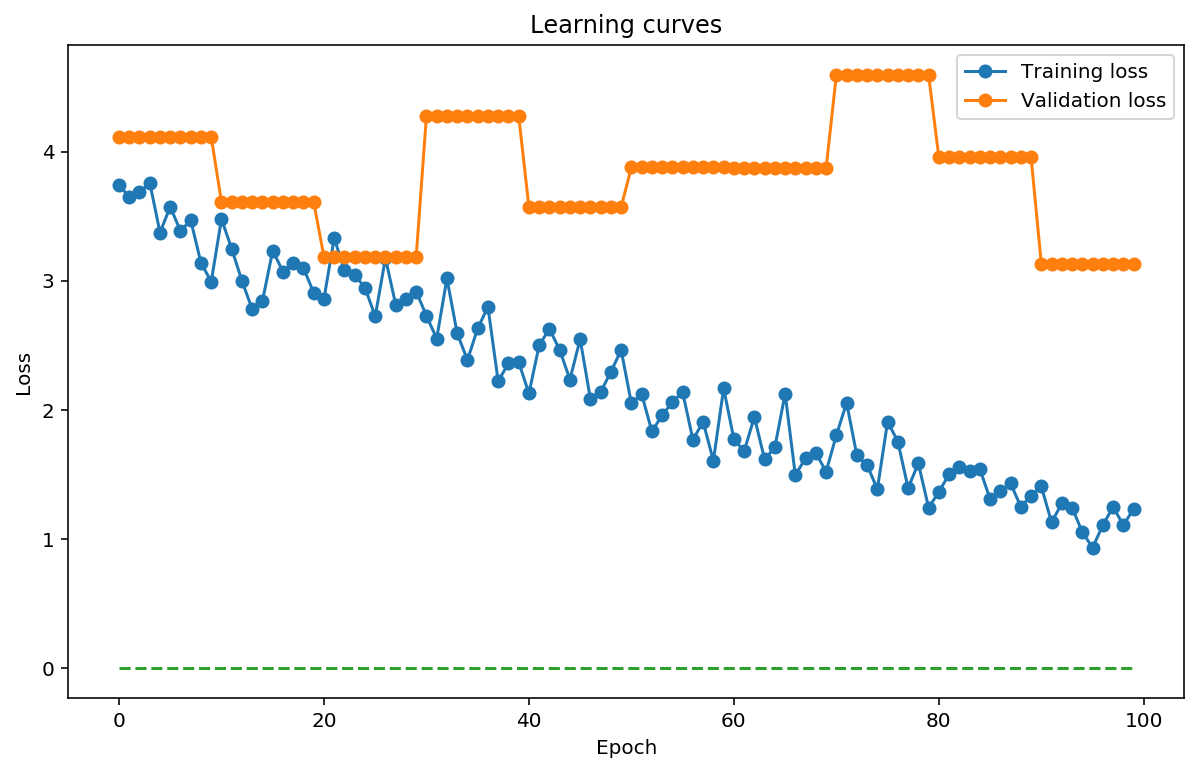

In [0]:
epochs = range(EPOCHS)

loss_obj=[0]*EPOCHS

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_train, '-o', label='Training loss')
plt.plot(epochs, loss_val, '-o', label='Validation loss')
plt.plot(epochs, loss_obj, '--')

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

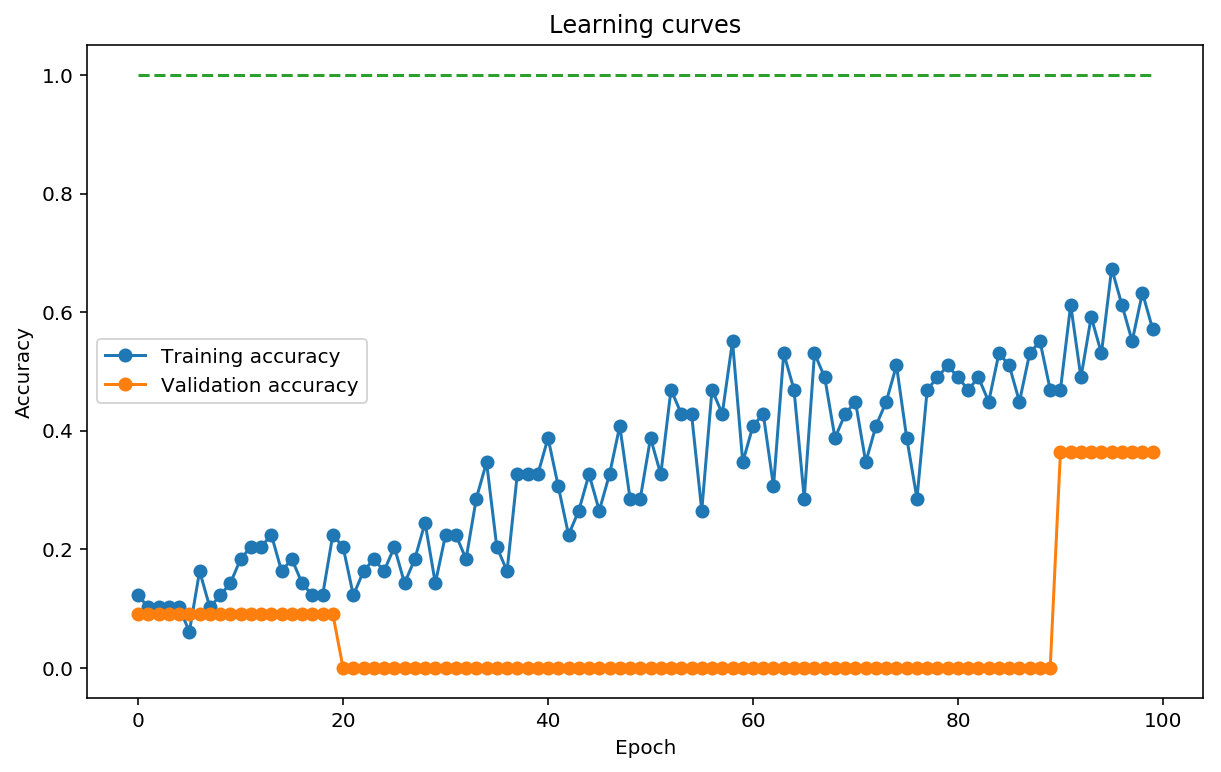

In [0]:
epochs = range(EPOCHS)

acc_obj=[1]*EPOCHS

plt.figure(figsize=(10,6))
plt.plot(epochs, acc_train, '-o', label='Training accuracy')
plt.plot(epochs, acc_val, '-o', label='Validation accuracy')
plt.plot(epochs, acc_obj, '--')

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

##Test#

In [0]:
# test

loss_test=[]
acc_test=[]

for i,batch in enumerate(testing_generator):
  x = batch[0]
  y = batch[1][:,0,:]
  x= x.to(device)
  y= y.to(device)
  y_pred = seq2oneMod.eval()(x)
  
  # Compute and print loss
  loss = seq2oneMod.loss(y_pred, y)
  acc  = seq2oneMod.accuracy(y_pred, y)
  
  loss_test.append(loss.item())
  acc_test.append(acc.item())

print(np.asarray(loss_test).mean(), np.asarray(acc_test).mean())
print(np.asarray(loss_test).std(), np.asarray(acc_test).std())


4.338741715749105 0.08804040203491846
0.4301707112203482 0.05046873794724644


##Generating/predicting#

In [0]:
def generateSeq2one(x, model ,pred_len=120):
  z= x.to(device)
  x1shape = x.shape[1]
  pred_shape=list(x.shape[1:])
  pred_shape[0] += pred_len
  pred_test=np.zeros(pred_shape)
  pred_test[0:x1shape,:] = x[0,:,:].numpy()                # we take the firdt samples from x 
  for i in range(pred_len):                                # predicting 
    y_pred = model.eval()(z)
    z[:,:-1,:] = z[:,1:,:]                # removing firt note
    z[0,-1,:]=0.0                         # add predicted note at the end
    z[0,-1,:][y_pred.argmax(dim=1)]=1.0   # add predicted note at the end  WARNING it be caodief here the 0.5 note
    pred_test[x1shape + i,:] = z[0,-1,:].cpu().numpy()  # add the new predicted to the pred_test
  return pred_test

def cleanSeq(x, cod_type):
  if cod_type==2:
    # first row correction
    notePos = np.where(x[0,:]==1)[0]        # where are the ones
    notePosWrong = np.array([aa%2 for aa in notePos])  
    notePosWrongPos = np.where(notePosWrong==1)[0]     # we look if corespond to odd positions
    x[0,notePos[notePosWrongPos]]=0                    # if present, we correct to 0 the odd
    x[0,notePos[notePosWrongPos]-1]=1                  # if present, we correct to 0 the correspondent even position
    
    # other rows correction
    # when we have 1 in even and odd position, then remove the second one 
    x[:,[ii for ii in range(x.shape[1]) if ii%2==1 ] ] = x[:,[ii for ii in range(x.shape[1]) if ii%2==1 ] ] * (1-x)[:,[ii for ii in range(x.shape[1]) if ii%2==0 ] ]

    # now we want to compare with previous row
    x_0 = x[1:,1:]     #   base values to correct
    x_1 = x[0:-1,1:]   #   previous same column
    x_11 = x[0:-1,0:-1]#   previous even column
    x_sel = np.zeros(x_0.shape)  # odd columns f x
    x_sel[:, [ii for ii in range(x_sel.shape[1]) if ii%2==0 ] ] =1   # corespond to even columns of x_sel
    x_2 = ((x_1==0) & (x_11==0) & (x_0==1) & (x_sel==1))   # columns with one in odd that not have any in even or odd correspondece in previous row
    x[1:,1:][x_2] = 0    # correction in unpair row
    x[1:,:-1][x_2] = 1
    
  return(x)


def create_midi(prediction_output, qnsf = 4, cod_type=2, midiOutputFile='test_output.mid'):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i,pattern in enumerate(prediction_output):
      # pattern is a note
      notes = []
      noteIndex = np.where(pattern==1)[0]
      noteIndex = noteIndex[[ii % cod_type ==0 for ii in noteIndex]]
      if len(noteIndex)>0:  
        for current_note in noteIndex:
          new_note = note.Note(int(current_note/cod_type + 21))
          new_note.storedInstrument = instrument.Piano()
          new_note.offset = offset
          # duration.quarterLength in case cod_type==2
          if cod_type==2 :
            # sequence of duration equal to one in the odd position
            auxDuration = np.where(prediction_output[(i+1):,current_note + 1]==1)[0]
            # initialize duration
            minimum_value = 0
            if len(auxDuration)>0:
              # minimum position where we have a consecuive sequence at 0
              # we add one to include complete sequences
              minimum_value = np.array(range(len(auxDuration)+1))[~np.isin(range(len(auxDuration)+1),auxDuration)].min()

            # we calcuate the minimum number in the sequance :len(auxDuration) that is not 
            # in the sequence, add one and divide by QNSF
            new_note.duration.quarterLength = ( minimum_value + 1.0)/qnsf
            
          output_notes.append(new_note)

      offset += 1.0/qnsf
    
    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=midiOutputFile)
    print("created midi file: ",midiOutputFile )


In [0]:
# generated length
PRED_LEN = 60

# we recover one song for the first sequence
pred_generator = data.DataLoader(dataset_test, batch_size=15, shuffle=False)
# pred

# transform to input tensor last batch
for i,batch in enumerate(pred_generator):
  xinit = batch[0]
#  break

pred_test = generateSeq2one(xinit,seq2oneMod,PRED_LEN)
if COD_TYPE==2:
  pred_test_clean = cleanSeq(pred_test, cod_type=COD_TYPE)
else:
  pred_test_clean = pred_test
create_midi(pred_test_clean, qnsf = QNSF, cod_type=COD_TYPE, midiOutputFile='test_output.mid')


created midi file:  test_output.mid
